In [124]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import en_core_web_sm
nlp = en_core_web_sm.load()

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from','nation','government','program','country', 'help', 'time', 'world', 'state', 'subject','year','people','applause', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [125]:
# In order to increase the accuracy of the topic models, we will pull out all nouns instead this time.
from nltk import word_tokenize, pos_tag

def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

In [126]:
data_clean = pd.read_pickle('data_clean.pkl')
data_nouns = pd.DataFrame(data_clean.transcript.apply(nouns))
data_nouns[:4]

,transcript
Barack Obama_2010,madam speaker vice president member congress americans constitution declare time time president ...
Barack Obama_2011,mr speaker vice president member congress americans congratulate man woman speaker john boehner ...
Barack Obama_2012,mr speaker vice president member congress americans month air force base home troop iraq proud s...
Barack Obama_2013,mr speaker vice president member congress citizens year kennedy chamber constitution power partn...


In [127]:
df = data_nouns

In [128]:
data = df.transcript.values.tolist()

In [129]:
import re
import gensim
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

In [130]:
data_words = list(sent_to_words(data))
print(data_words[:1])

[['madam', 'speaker', 'vice', 'president', 'member', 'congress', 'americans', 'constitution', 'declare', 'time', 'time', 'president', 'information', 'state', 'union', 'year', 'leader', 'fulfil', 'duty', 'period', 'prosperity', 'tranquility', 'war', 'depression', 'moment', 'struggle', 'moment', 'progress', 'america', 'destine', 'union', 'turn', 'bull', 'beach', 'victory', 'doubt', 'market', 'crash', 'tuesday', 'right', 'future', 'time', 'test', 'courage', 'conviction', 'strength', 'union', 'division', 'disagreement', 'hesitation', 'fear', 'prevail', 'choose', 'nation', 'people', 'answer', 'year', 'office', 'war', 'economy', 'rock', 'recession', 'system', 'verge', 'collapse', 'government', 'debt', 'spectrum', 'warn', 'act', 'depression', 'act', 'year', 'storm', 'pass', 'devastation', 'americans', 'work', 'business', 'shutter', 'home', 'value', 'town', 'community', 'life', 'recession', 'compound', 'burden', 'family', 'deal', 'decade', 'burden', 'work', 'harder', 'save', 'retire', 'help', 

In [131]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [132]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=1000,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.012*"terrorist" + 0.009*"terror" + 0.006*"iraqi" + 0.006*"enemy" + '
  '0.006*"regime" + 0.005*"relief" + 0.004*"coalition" + 0.004*"murder" + '
  '0.004*"intelligence" + 0.004*"inspector"'),
 (1,
  '0.004*"aggression" + 0.003*"park" + 0.003*"domination" + 0.003*"beauty" + '
  '0.003*"search" + 0.003*"fulfill" + 0.003*"currency" + 0.003*"unity" + '
  '0.003*"agent" + 0.002*"millennium"'),
 (2,
  '0.024*"increase" + 0.013*"tax" + 0.013*"peace" + 0.013*"price" + '
  '0.012*"inflation" + 0.010*"growth" + 0.010*"strength" + 0.010*"energy" + '
  '0.009*"percent" + 0.009*"problem"'),
 (3,
  '0.017*"work" + 0.013*"family" + 0.011*"job" + 0.009*"budget" + 0.009*"let" '
  '+ 0.008*"today" + 0.008*"economy" + 0.007*"freedom" + 0.007*"child" + '
  '0.007*"tonight"')]


In [133]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [134]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.9519,"work, family, job, budget, let, today, economy, freedom, child, tonight","[member, declare, leader, duty, period, prosperity, depression, moment, struggle, moment, progre..."
1,1,3.0,0.9992,"work, family, job, budget, let, today, economy, freedom, child, tonight","[member, tonight, difference, debate, fight, thing, democracy, demand, reason, family, race, poi..."
2,2,3.0,0.8765,"work, family, job, budget, let, today, economy, freedom, child, tonight","[member, month, home, troop, proud, life, gather, tonight, generation, hero, decade, defeat, tro..."
3,3,3.0,0.9993,"work, family, job, budget, let, today, economy, freedom, child, tonight","[member, partner, task, tonight, home, recession, business, create, job, car, oil, housing, mark..."
4,4,3.0,0.9993,"work, family, job, budget, let, today, economy, freedom, child, tonight","[member, today, student, lift, graduation, rate, level, decade, entrepreneur, flip, tech, job, b..."
5,5,3.0,0.9245,"work, family, job, budget, let, today, economy, freedom, child, tonight","[member, dawn, terror, touch, shore, generation, fight, war, recession, spread, turn, page, econ..."
6,6,3.0,0.9991,"work, family, job, budget, let, today, economy, freedom, child, tonight","[member, laughter, hand, tip, laughter, election, season, expectation, appreciate, approach, lea..."
7,7,3.0,0.9993,"work, family, job, budget, let, today, economy, freedom, child, tonight","[member, speech, teleprompter, tonight, laughter, hope, ask, memory, son, tip, send, tonight, ga..."
8,8,3.0,0.9920,"work, family, job, budget, let, today, economy, freedom, child, tonight","[member, democracy, democracy, let, congratulate, agree, look, hear, work, founder, change, cour..."
9,9,3.0,0.9991,"work, family, job, budget, let, today, economy, freedom, child, tonight","[member, peace, family, community, responsibility, word, founder, form, union, economy, decade, ..."


In [135]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,2.0,0.6005,"increase, tax, peace, price, inflation, growth, strength, energy, percent, problem","[member, yesterday, experience, charge, election, chance, search, peace, today, recession, infla..."
1,3.0,0.9993,"work, family, job, budget, let, today, economy, freedom, child, tonight","[member, partner, task, tonight, home, recession, business, create, job, car, oil, housing, mark..."


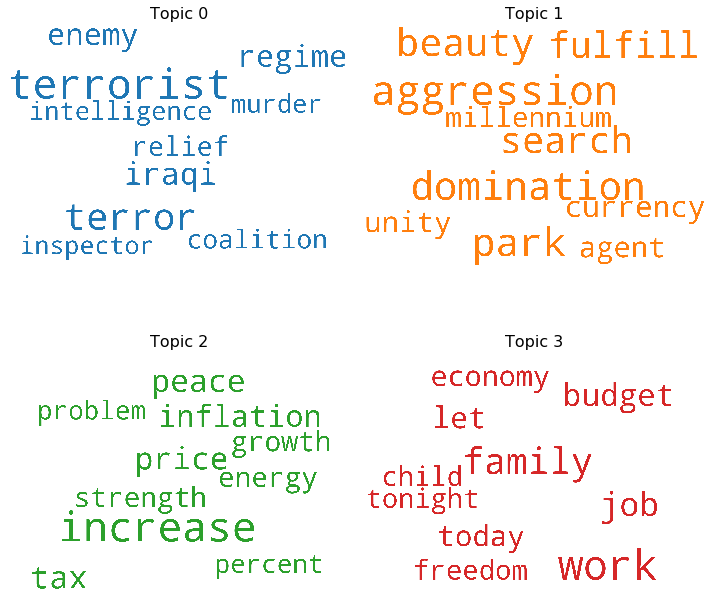

In [136]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

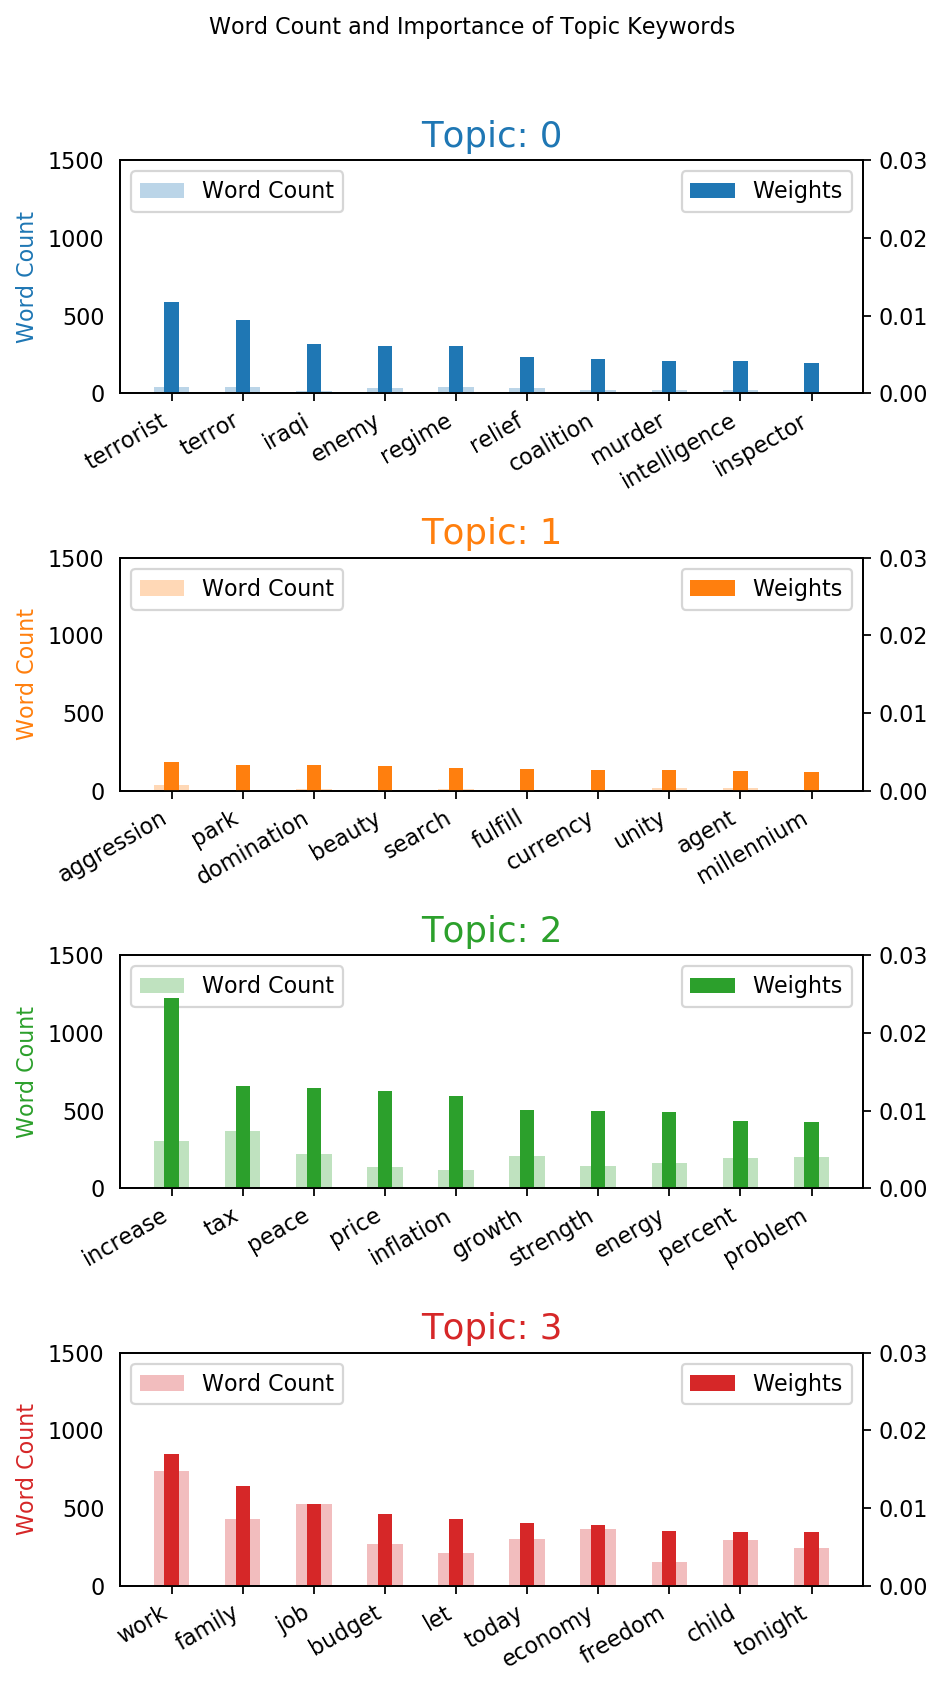

In [137]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4, 1, figsize=(6,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0,1500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=10, y=1.05)    
plt.show()

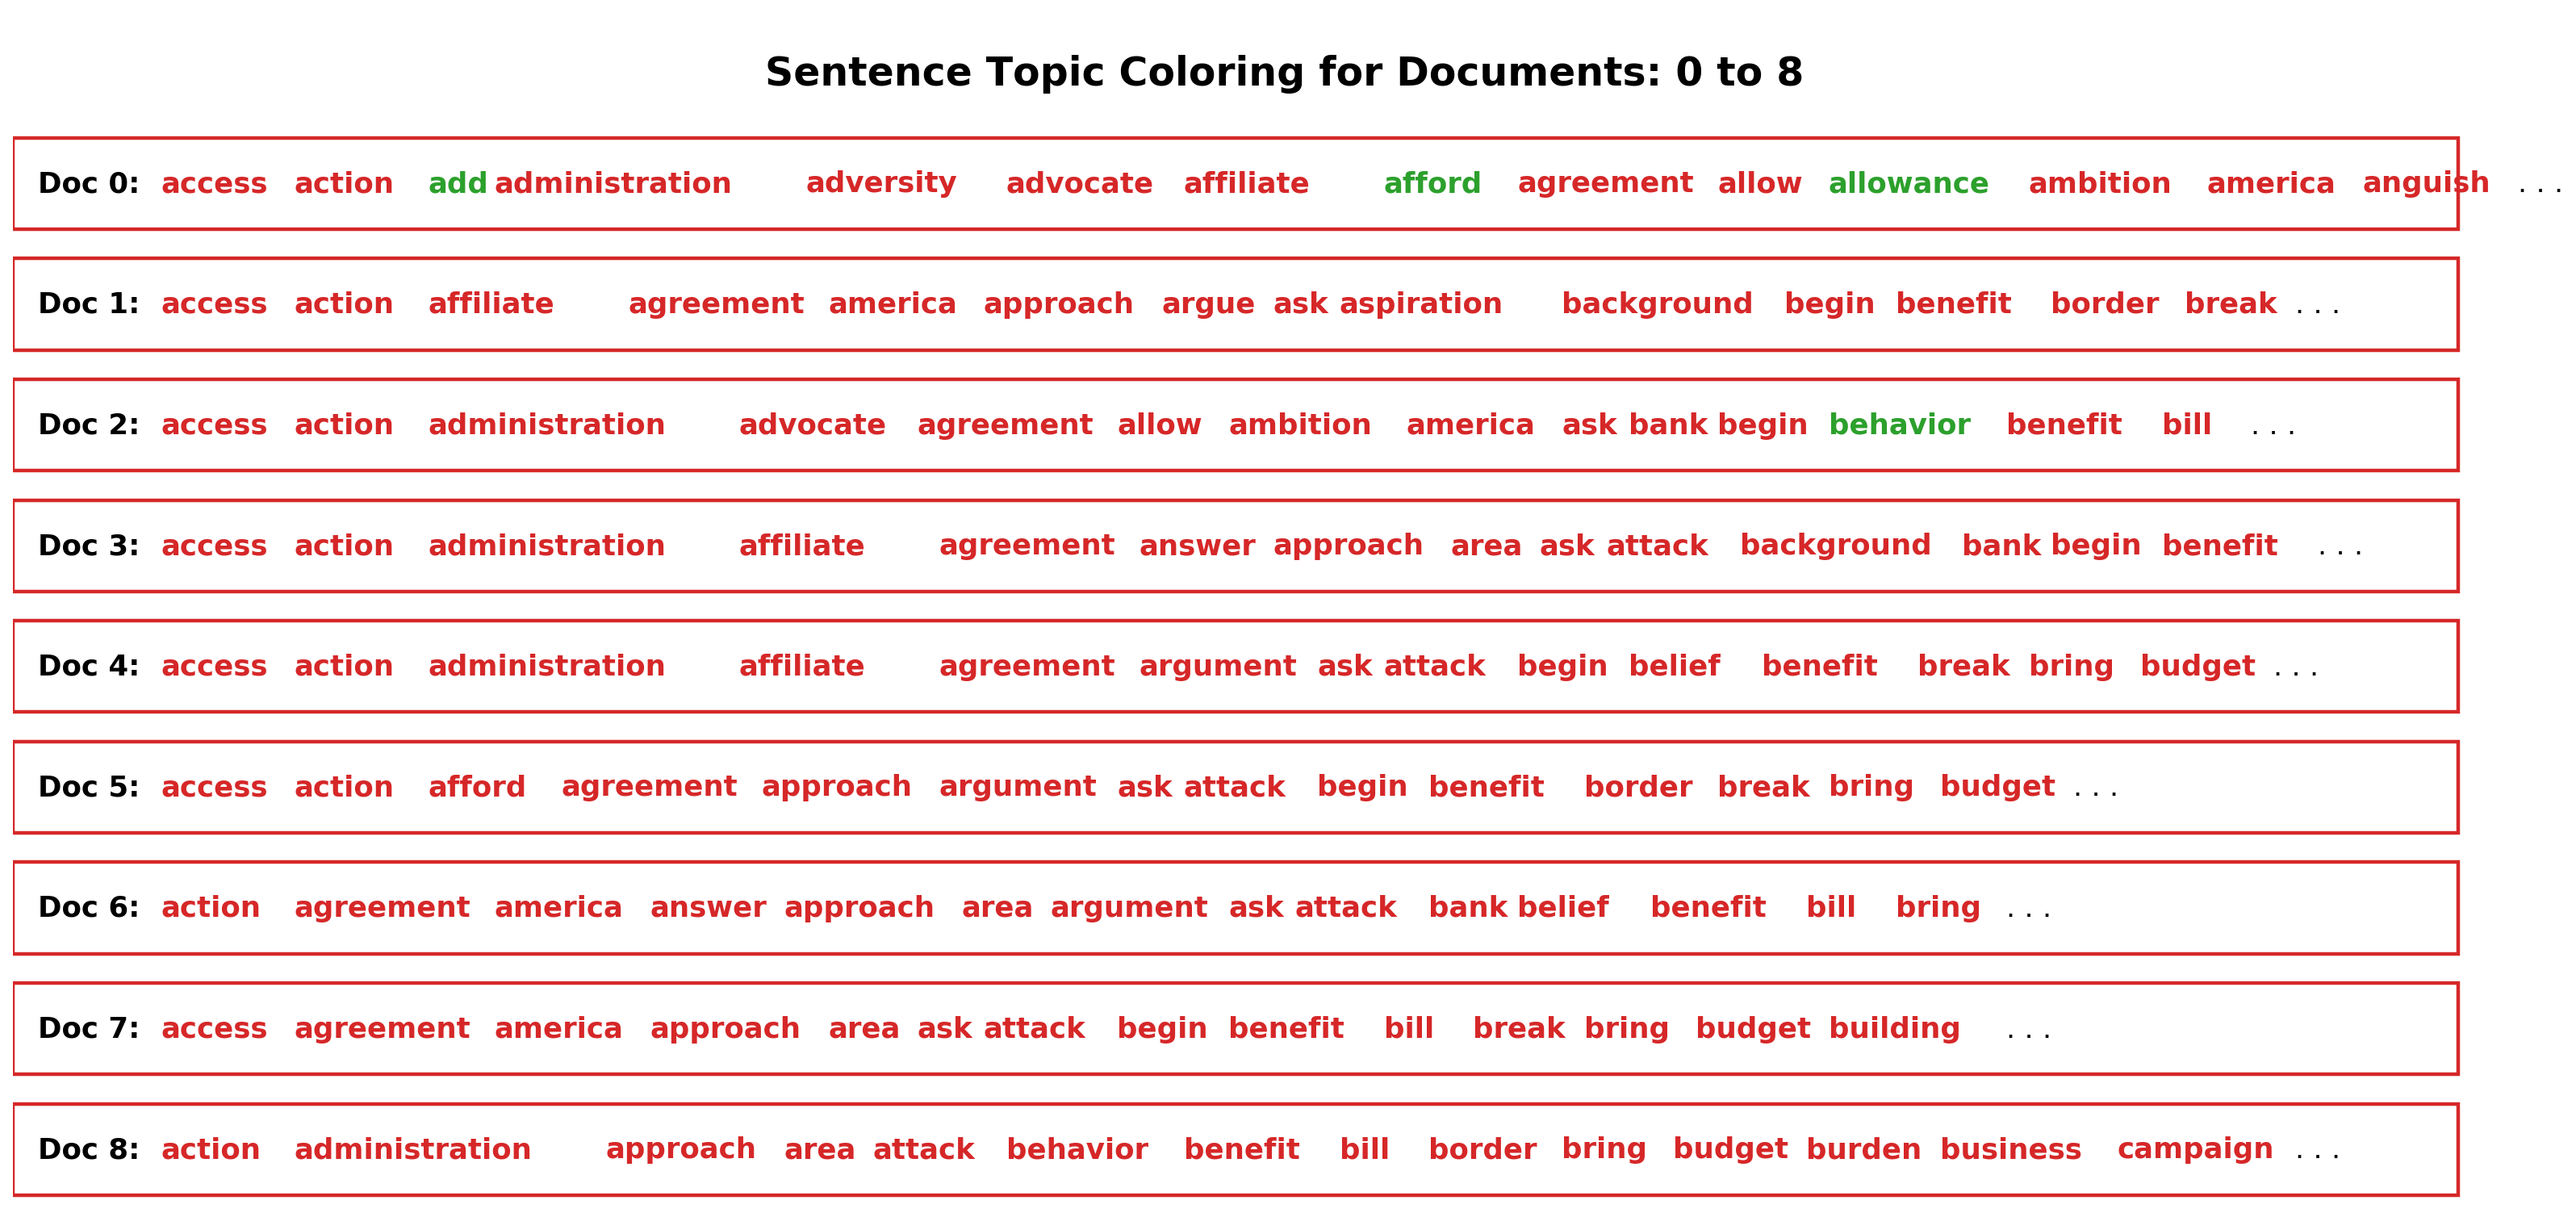

In [138]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 10):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

In [139]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

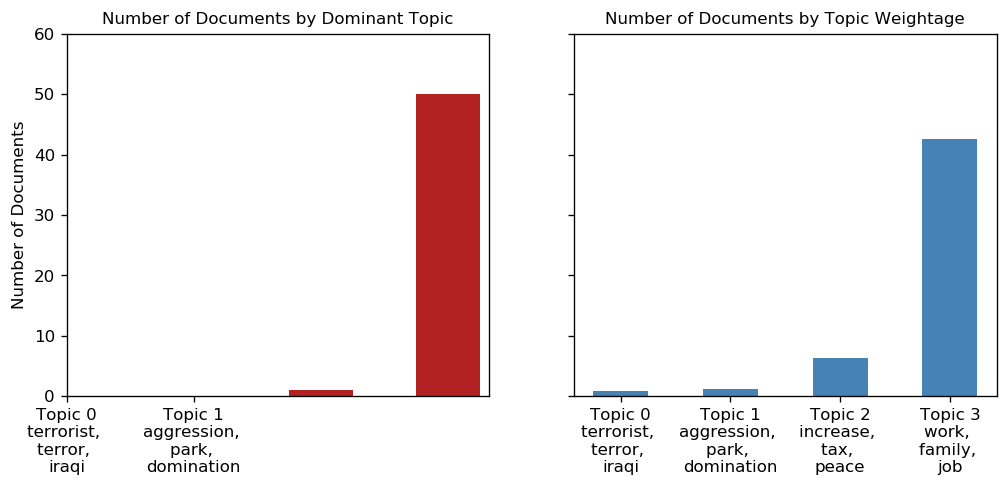

In [140]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 60)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [141]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 51 nearest neighbors...
[t-SNE] Indexed 52 samples in 0.000s...
[t-SNE] Computed neighbors for 52 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 52 / 52
[t-SNE] Mean sigma: 0.238105
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.116272
[t-SNE] KL divergence after 1000 iterations: 0.246298


Loading BokehJS ...

In [142]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

C:\Users\alanl\Anaconda3\envs\py37\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.245026  0.078782       1        1  84.696648
2     -0.027370 -0.184262       2        1  11.673429
1      0.150794  0.049117       3        1   2.077635
0      0.121602  0.056363       4        1   1.552291, topic_info=     Category        Freq       Term       Total  loglift  logprob
237   Default  272.000000   increase  272.000000  30.0000  30.0000
435   Default  288.000000        tax  288.000000  29.0000  29.0000
308   Default  238.000000      peace  238.000000  28.0000  28.0000
213   Default  225.000000     growth  225.000000  27.0000  27.0000
1315  Default  127.000000  inflation  127.000000  26.0000  26.0000
...       ...         ...        ...         ...      ...      ...
2287   Topic4    1.043419       well    2.719535   3.2075  -6.4634
2508   Topic4    1.103963   dividend    3.300721   3.0702  -6.4070
2556   Topic4    1.146549    witness    3.738313   2.9836  -6.3692
697    Topic4    1.093068       show   19.287045   1.2950  -6.4169
2285   Topic4    1.023198    tyranny    3.647808   2.8942  -6.4830

[242 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
2558      4  0.561827     abstinence
2885      2  0.991211      abundance
2835      2  0.889629  accommodation
1861      3  0.427743          adopt
7         1  0.160609         afford
...     ...       ...            ...
2556      1  0.535001        witness
2556      4  0.267500        witness
2686      4  0.689555           wood
486       1  0.998890           work
487       1  0.998342         worker

[299 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 1])